# Introduction
The aim of this project is to successfully develop a model that can predict soil moisture content on the 30th day ahead of the data, in other words, to successfully forecast the soil moisture content of the ground from the data that is provided by the German Meteorological Service from Münster, Deutscher Wetterdienst (n.d.), by utilizing either non-neural machine learning models or models that utilize neural networks and compare the outcomes and determine which method is more suitable in forecasting said values.
From the non-neural machine learning methods two models will be tested; a Linear Regression model and a Random Forest Regressor will be used and after evaluation, only one will be used to forecast. When developing the neural network model, a LSTM (Long Short-Term Memory)  will be used.

## The Contents of the Dataset
**DATUM**: The datetime column

**STATIONS_ID**	DWD weather station ID
  * 1766 = Münster/Osnabrück

**QN_4**: quality level of TT_TER and RF_TER columns
  * 1- only formal control during decoding and import
  * 2- controlled with individually defined criteria
  * 3- ROUTINE control with QUALIMET and QCSY
  * 5- historic, subjective procedures
  * 7- ROUTINE control, not yet corrected
  * 8- quality control outside ROUTINE
  * 9- ROUTINE control, not all parameters corrected
  * 10- ROUTINE control finished, respective corrections finished

**TT_TER**: air temperature

**RF_TER**: relative humidty

**VGSL**: real evapotranspiration over gras and sandy loam (mm)

**TS05**: mean daily soil temperature in 5 cm depth for uncovered typical soil (°C)

**BF10**: soil moisture under grass and sandy loam between 0 and 10 cm depth in % plant useable water (%nFK) (Gyarmathy, 2022)

# Approach
There are many available programming languages that can be used for data science purposes, such as R or even a more general use languages such as C# to conduct similar projects, such as forecasting, speech recognition, etc. However, there are two main programming languages preferred by data scientists worldwide, one being R and the second one being Python. For the purpose of completing this project the language used is Python due to 2 key reasons. The first reason being is the already established knowledge and experience using Python And the unfamiliarity of using R, although it would be interesting to compare the two programming languages, the sheer familiarity and ease of use of Python makes it a great tool for this project. The second reason being the popularity of Python and the ease of use of said programming language. Moreover, the abundance of data science libraries that is available for Python.

As mentioned before, since there are so many libraries that are available for Python, we had to choose between two main libraries that will be used for this project, that being Pytorch and Tensorflow Keras. While many regard Pytorch to be an easier alternative to learn, during our studies, we have mainly focused on tensor flow and Keras when learning about deep learning and neural networks. Furthermore, tensor flow 1 had a very steep learning curve and the library wasn't very user friendly and with the rise of Tensorflow 2 and the integration with Keras, it has become easier to learn, provides a more user-friendly approach than its predecessor, and has many tools that make it a more desirable library for data scientists. Lastly, since the aim of this project is to compare non-neural machine learning models with neural network models, another widely popular tool that will be used is SciKit learn for the non-neural machine learning models.

## Model Selection

It was briefly touched upon in the introduction that two models will be used, one being linear regression and the second one being an LSTM model. However, the plan beforehand was to incorporate many other different models and test them each. On the non neural machine learning side, many other regressors were to be used other than linear regression such as random forest regressor, etc. and timeseries specific models such as AutoReg(), ARIMA, SARIMA and SARIMAX. These were the models that needed to be tested and the most effective model was to be used for the forecast of the soil moisture content.

The reason for the incorporation of autoregressive models was the following. As many of the autoregressive regression models is built on top of the concept of autocorrelation and partial autocorrelation, or in other words, where the dependent variable depends on the past values of itself. An example might be where temperature today may depend on the temperature yesterday and the days before.  Unfortunately due to heavy time constraints and hardware difficulties, the auto regressive models had to be cut to prioritize the linear regression model and the LSTM model. 

When selecting a neural network model to predict the soil moisture levels, it was important to review the options. While there are many good models for predicting time series data, ultimately using an LSTM was chosen as the favorable approach due to familiarity. Whilst recurrent neural networks (RNN) have short term memory that utilize past data in the current neural network, which makes it ideal for predicting data in a time series, most recurrent neural networks face the problem of vanishing gradients, which can be interpreted as a loss in information due to the repeated use of the recurrent weight matrix. However, in an LSTM model, and identify function is managed by a set of gates that replaces the recurrent weight matrix. The weights are controlled by the input, output, and forget gates, which work together to generate the long-term memory function and in turn eliminates the vanishing gradient problem.

In [ ]:
!wget https://drive.google.com/uc?export=download&id=173tvWt-qPyAqZJc1KoBiUHgoSg6nLUtT

In [3]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, LSTM
# from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data Preparation

Before any manipulation of the data were to occur it is important to analyze the data set before any modifications are made on it.  It is also important to set a random seed for reproducibility of the project.  Since all the information regarding the columns was provided in the project description before, we can read the CSV while simultaneously parsing the dates column labeled as DATUM.  It is important to analyze the data and its properties, such as the variables, columns, properties, mean, variance, standard deviation, etc.  and to visualize the data set  as simple visualization can give away any potential outliers, errors, NaN values, and be able to identify underlying trends and/or seasonality. After printing out the relevant information, it can be concluded that the data set contains a little over 35,000 records, data spanning from the beginning of the year 1991 to the end of year 2021.  The data set also contains seven additional features that have been described in the above paragraphs.  After calling the .info() function, it can be observed that the DATUM column is a datetime64 object and the data set does not contain any null values and that two of the columns are indeed measurements taken three times a day.

 

In [4]:
# Set random seed for reproductibility
random_seed = 69
np.random.seed(random_seed)

# Read the dataset and print out the information
df = pd.read_csv('munster_hourly.csv', parse_dates=["DATUM"])
df

,DATUM,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
0,1991-01-01 07:00:00,1766,10,3.0,91.0,0.3,2.9,102
1,1991-01-01 14:00:00,1766,10,4.8,85.0,0.3,2.9,102
2,1991-01-01 21:00:00,1766,10,3.9,82.0,0.3,2.9,102
3,1991-01-02 07:00:00,1766,10,5.6,94.0,1.4,6.3,110
4,1991-01-02 14:00:00,1766,10,11.0,87.0,1.4,6.3,110
...,...,...,...,...,...,...,...,...
35667,2021-12-30 00:00:00,1766,1,11.6,90.0,0.8,9.4,104
35668,2021-12-30 06:00:00,1766,1,11.1,98.0,0.8,9.4,104
35669,2021-12-30 12:00:00,1766,1,14.3,83.0,0.8,9.4,104
35670,2021-12-30 18:00:00,1766,1,13.5,90.0,0.8,9.4,104


In [5]:
# Visualize the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATUM        35672 non-null  datetime64[ns]
 1   STATIONS_ID  35672 non-null  int64         
 2   QN_4         35672 non-null  int64         
 3   TT_TER       35672 non-null  float64       
 4   RF_TER       35672 non-null  float64       
 5   VGSL         35672 non-null  float64       
 6   TS05         35672 non-null  float64       
 7   BF10         35672 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 2.2 MB


In [7]:
df.describe()

,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
count,35672.0,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000
mean,1766.0,8.641540,10.755136,76.796675,1.236676,11.096577,70.367739
std,0.0,2.772131,7.591943,18.688003,0.978120,7.684733,37.325784
min,1766.0,1.000000,-21.300000,-999.000000,0.000000,-8.000000,0.000000
25%,1766.0,10.000000,5.200000,65.000000,0.500000,4.600000,40.000000
50%,1766.0,10.000000,10.600000,81.000000,1.000000,10.900000,87.000000
75%,1766.0,10.000000,16.100000,91.000000,1.800000,17.500000,102.000000
max,1766.0,10.000000,37.700000,100.000000,6.300000,29.200000,111.000000


In [8]:
print(df['STATIONS_ID'].unique())
print(df['QN_4'].unique())

[1766]
[10  3  1]


Lastly, the describe function also gives us a lot of. Lastly, the describe function also gives us a lot of useful information. From this table we can conclude that the stations ID. Dropped as it only contains a single variable 1766.  Another feature that can be excluded is feature QN_4 as the data is mostly category 10 with a few categories 3 and 1.  We can also conclude that RF_TER has at least one obvious outlier, that being -999.  As this variable stands for relative humidity, such a low variable is impossible and can be safely discarded.  To get a better understanding of this dataset, the columns can also be plotted into a graph for better visualization purposes.

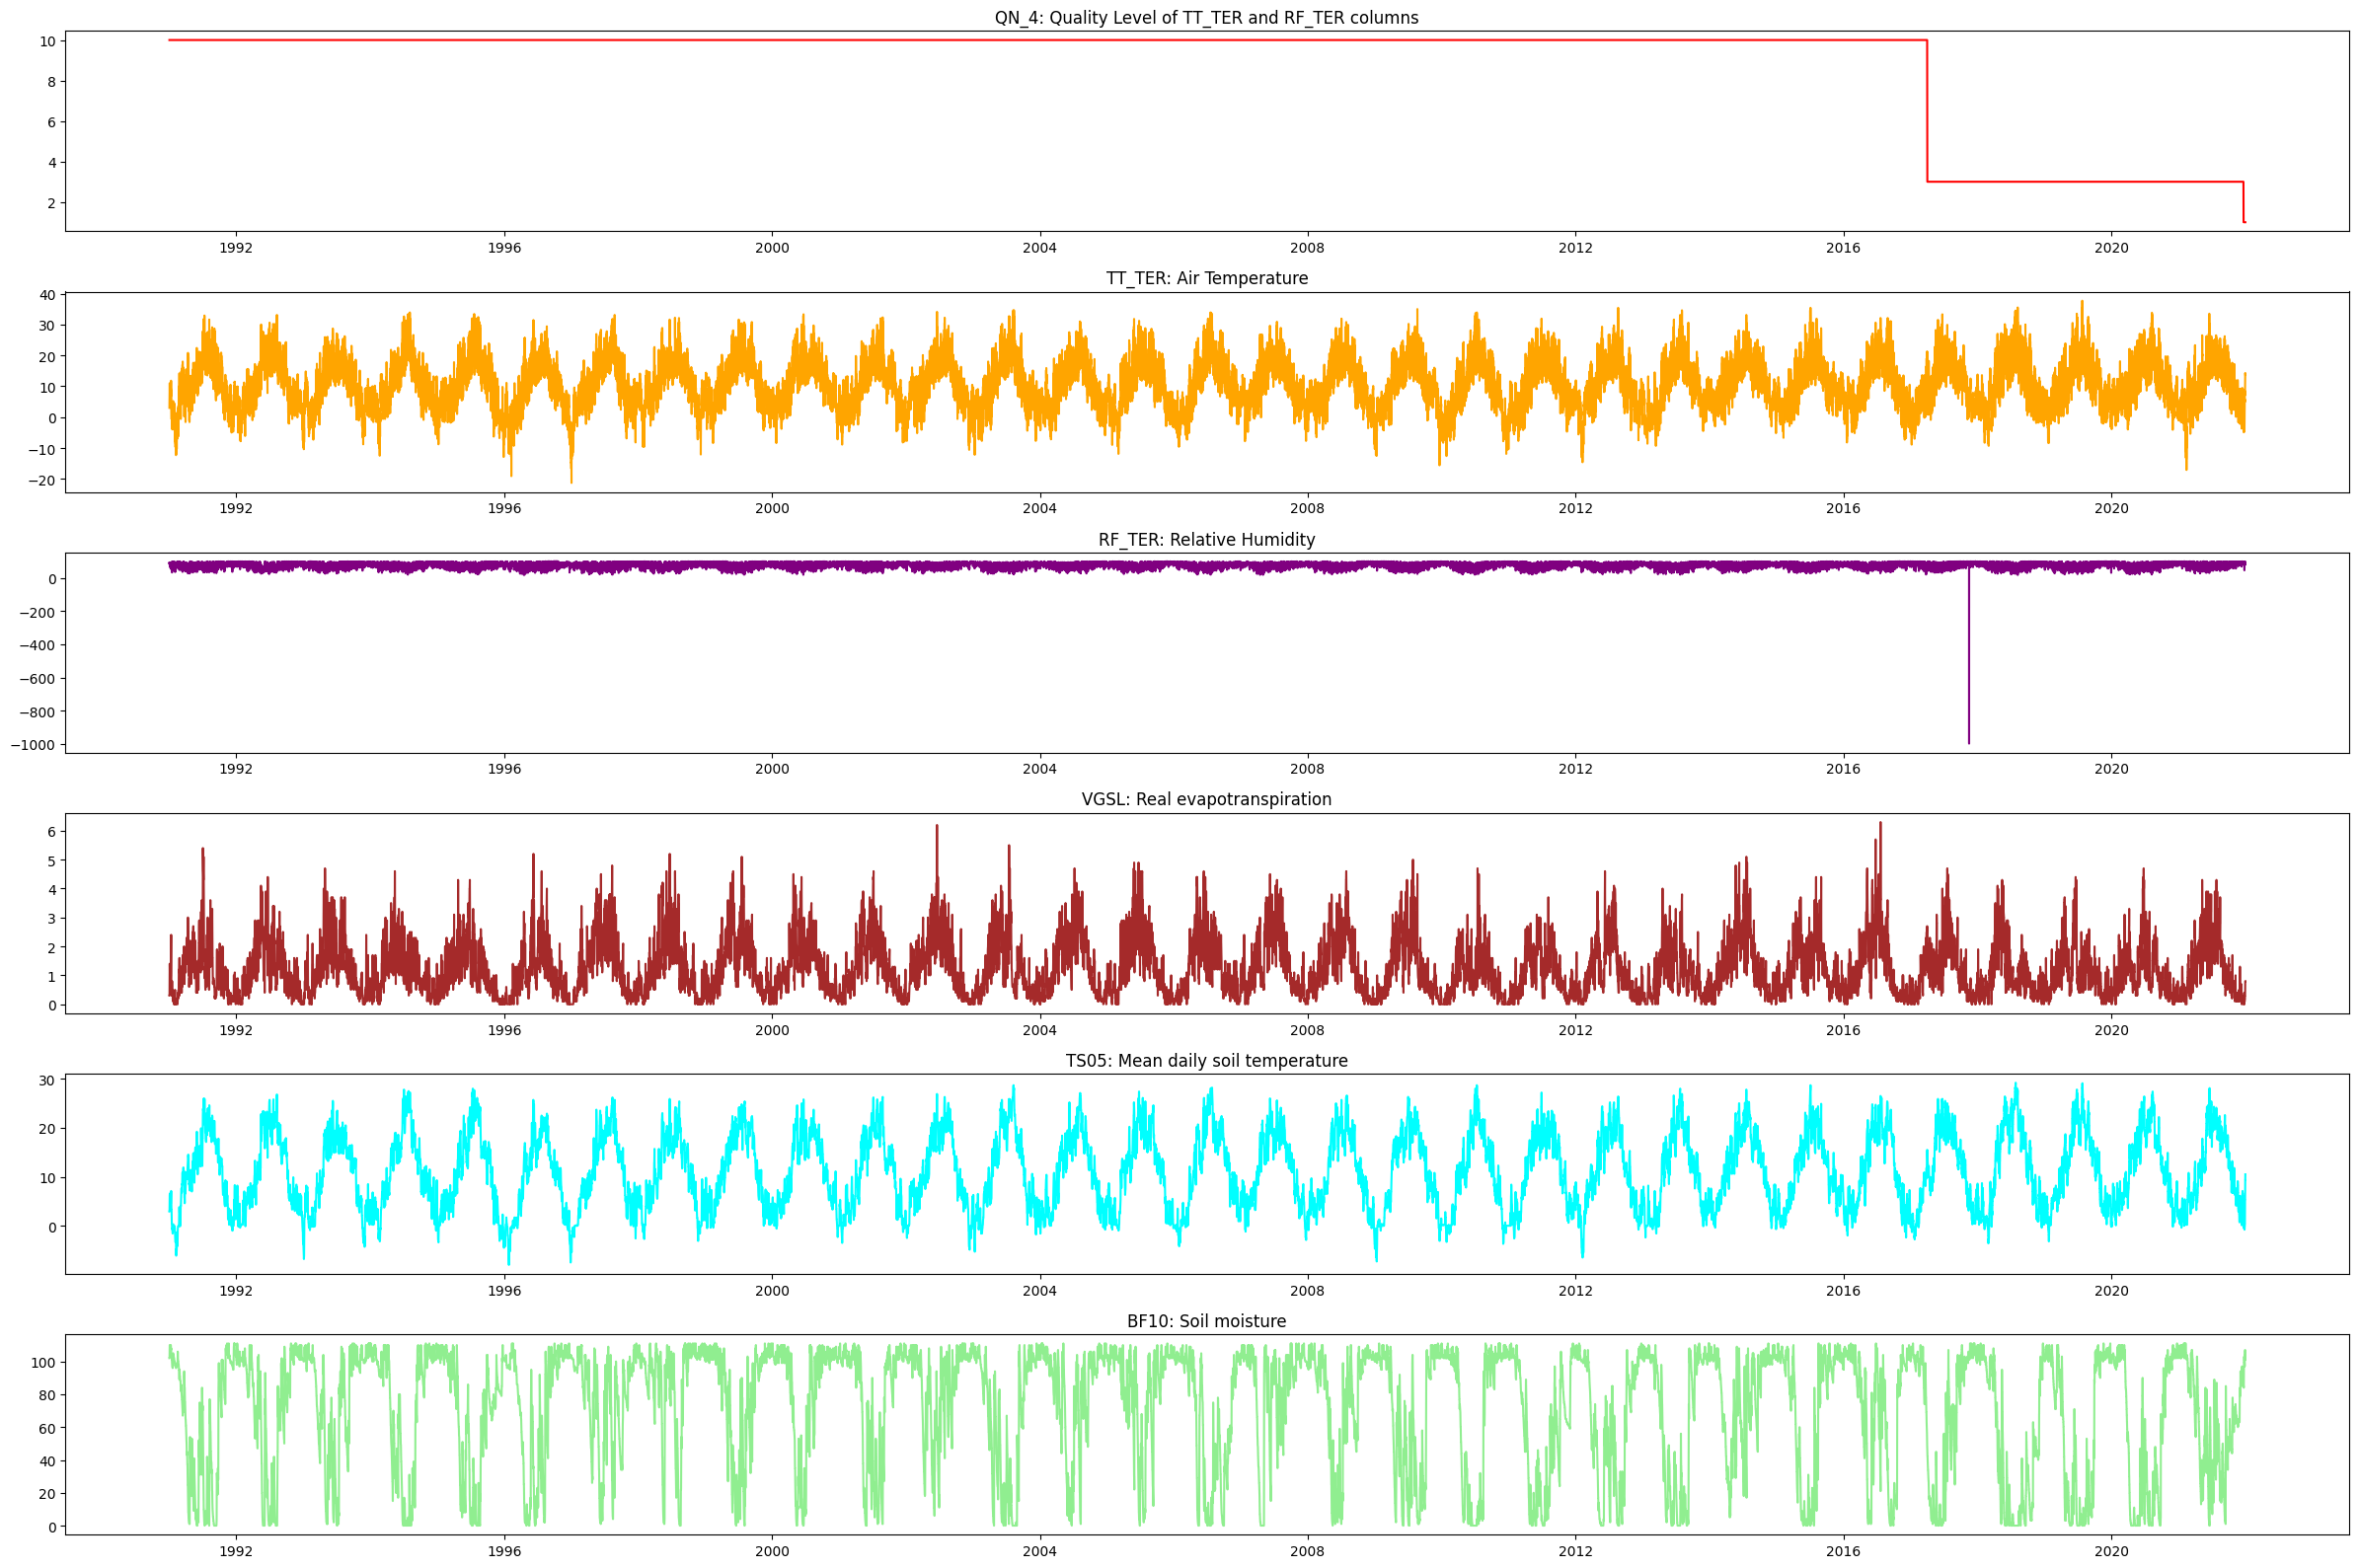

In [16]:
plt.figure(figsize=(24,16))

plt.subplot(6, 1, 1)
plt.title('QN_4: Quality Level of TT_TER and RF_TER columns')
plt.plot(df['DATUM'],df['QN_4'], c = 'red')

plt.subplot(6, 1, 2)
plt.title('TT_TER: Air Temperature')
plt.plot(df['DATUM'],df['TT_TER'], c = 'orange')

plt.subplot(6, 1, 3)
plt.title('RF_TER: Relative Humidity')
plt.plot(df['DATUM'],df['RF_TER'], c = 'purple')

plt.subplot(6, 1, 4)
plt.title('VGSL: Real evapotranspiration')
plt.plot(df['DATUM'],df['VGSL'], c = 'brown')

plt.subplot(6, 1, 5)
plt.title('TS05: Mean daily soil temperature')
plt.plot(df['DATUM'],df['TS05'], c = 'cyan')

plt.subplot(6, 1, 6)
plt.title('BF10: Soil moisture')
plt.plot(df['DATUM'],df['BF10'], c = 'lightgreen')

plt.tight_layout()
plt.show()

Before starting the data cleaning process, it is also important to view the correlation matrix between the different features to see if there is any relationship between them and to see what sort of effect the independent variables have on the dependent variable. This step is very important as it determines which columns will be dropped and which will be kept and used in the future to predict the soil moisture content in the ground.

After careful observations and considerations, it was determined that going forward, the only necessary columns will be the soil moisture column (BF10) and the DATUM column, which will be used as an index in the future. The reason for the following decision is that the STATIONS_ID column is unnecessary as there is only one station that has done all the measurements, therefore it is redundant. The column QN_4 is also unnecessary as it only displays the category of measurements and lastly, all the other columns except for column RF_TER show a negative correlation with our dependent variable of BF_10.

C:\Users\Robert Rompf\AppData\Local\Temp\ipykernel_10428\434535873.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  sns.heatmap(df.drop('STATIONS_ID', 1).corr(), cmap="YlGnBu", annot=True)
C:\Users\Robert Rompf\AppData\Local\Temp\ipykernel_10428\434535873.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.drop('STATIONS_ID', 1).corr(), cmap="YlGnBu", annot=True)


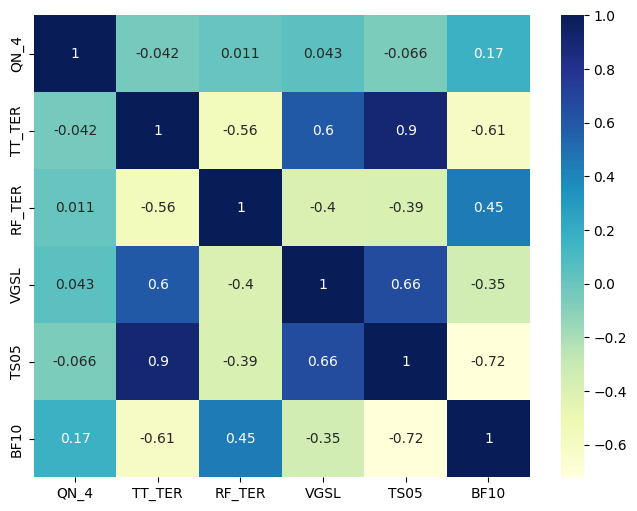

In [25]:
df = df[df.RF_TER > 0]
# DataFrame Correletion Heatmap
plt.figure(figsize = (8,6))
sns.heatmap(df.drop('STATIONS_ID', 1).corr(), cmap="YlGnBu", annot=True)
plt.show()

In [26]:
df2 = df.copy()
df2 = df2[["DATUM", "BF10"]]
df2.DATUM = df2.DATUM.astype('datetime64[ns]')
df2 = df2.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()
df2['BF10'] = df2["BF10"].astype('int32')
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1991-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   BF10    11323 non-null  int32
dtypes: int32(1)
memory usage: 132.7 KB


In [27]:
df2

,BF10
DATUM,
1991-01-01,102
1991-01-02,110
1991-01-03,110
1991-01-04,106
1991-01-05,109
...,...
2021-12-27,97
2021-12-28,104
2021-12-29,107


 After cleaning the dataset, it is important to visualize the soil moisture values over the years. In the beginning, the hypothesis stated that the soil moisture content over the year is a seasonal occurrence, or in other words, cyclic. Henceforth, during the winter months the soil moisture contents will be high and during the summer months due to heat and higher rates of evaporation, the soil moisture content will be low.  After visualizing the soil moisture content over the years, we can see that this is pretty much the case.

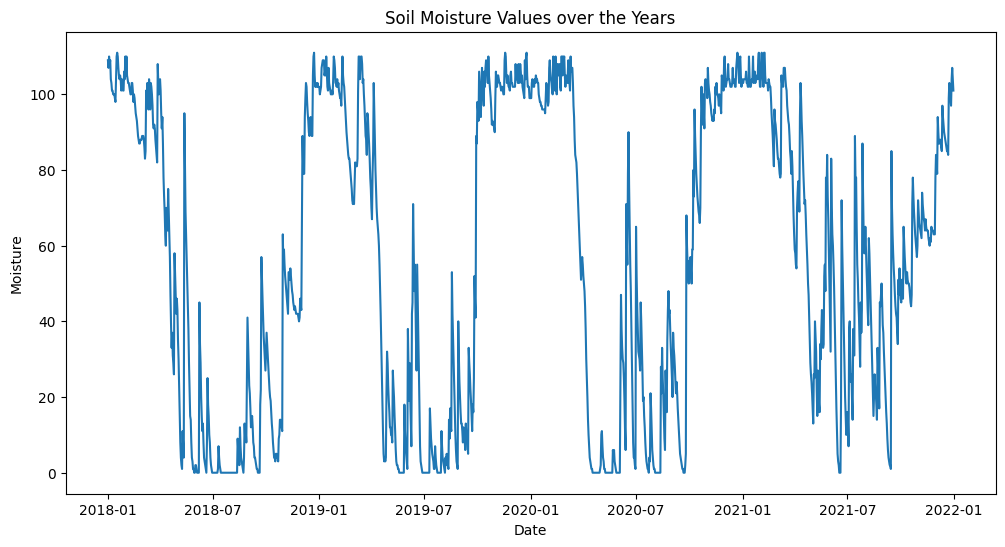

In [28]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(df2['BF10']['2018':])

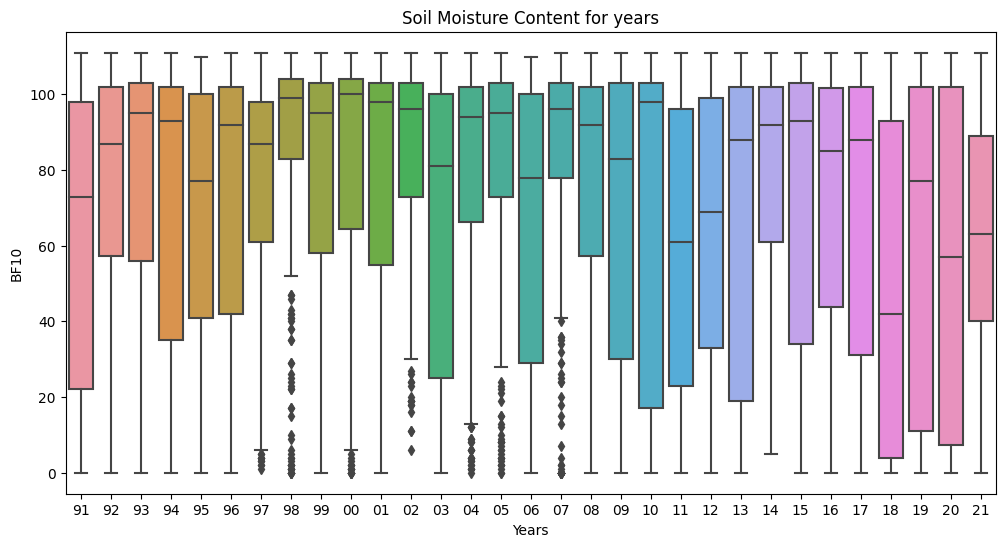

In [29]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x=df2.index.strftime("%y"), y=df2["BF10"])
plt.title("Soil Moisture Content for years")
plt.xlabel("Years")
plt.show()

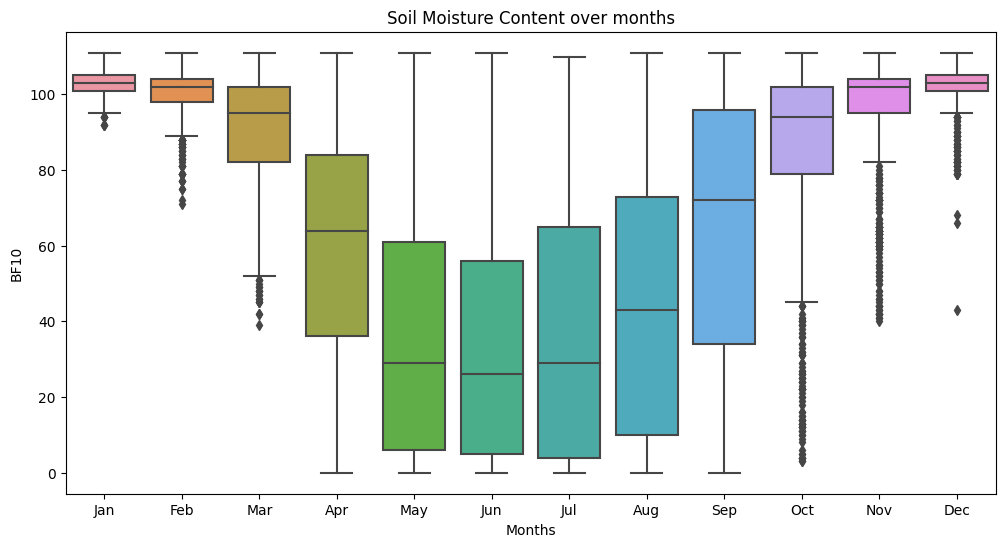

In [30]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x=df2.index.strftime("%b"), y=df2["BF10"], ax=ax)
plt.title("Soil Moisture Content over months")
plt.xlabel("Months")
plt.show()

In [11]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')
        
check_stationarity(df2)

The series is stationary


/tmp/ipykernel_321/2753353209.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  analysis = seasonal_decompose(df2['2020'], model='additive', extrapolate_trend=12)


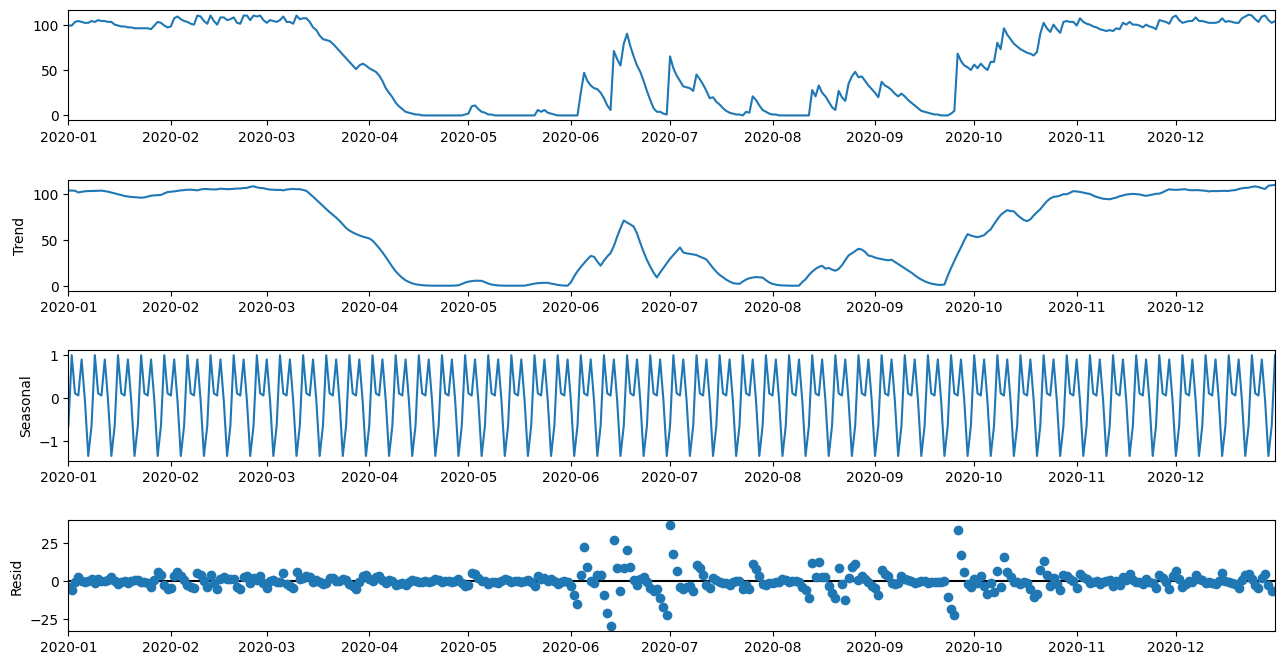

In [12]:
analysis = seasonal_decompose(df2['2020'], model='additive', extrapolate_trend=12)
    
fig = analysis.plot()
fig.set_size_inches(14, 7)
plt.show()

## Linear Regression and Random Forest Regressor

In [18]:
reindexed_df = df.copy()
reindexed_df = reindexed_df[["DATUM", "BF10", "RF_TER"]]
reindexed_df.DATUM = reindexed_df.DATUM.astype('datetime64[ns]')
reindexed_df = reindexed_df.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()
reindexed_df['BF10'] = reindexed_df["BF10"].astype('int32')
reindexed_df['RF_TER'] = reindexed_df["RF_TER"].astype('float32')
reindexed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1991-01-01 to 2021-12-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BF10    11323 non-null  int32  
 1   RF_TER  11323 non-null  float32
dtypes: float32(1), int32(1)
memory usage: 176.9 KB


In [19]:
X = reindexed_df[["RF_TER"]]

y = reindexed_df[['BF10']]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.10, random_state=random_seed)

In [20]:
forest = RandomForestRegressor().fit(X_train, y_train)
linear = LinearRegression().fit(X_train, y_train)

/tmp/ipykernel_321/4150774867.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest = RandomForestRegressor().fit(X_train, y_train)


In [21]:
forest_pred = forest.predict(X_test)
lr_pred = linear.predict(X_test)

predictions = pd.DataFrame(lr_pred, index = y_test.index, columns = ['Prediction_Linear'])
predictions['Prediction_Forest'] = forest_pred
predictions['Actuals'] = np.array(y_test)

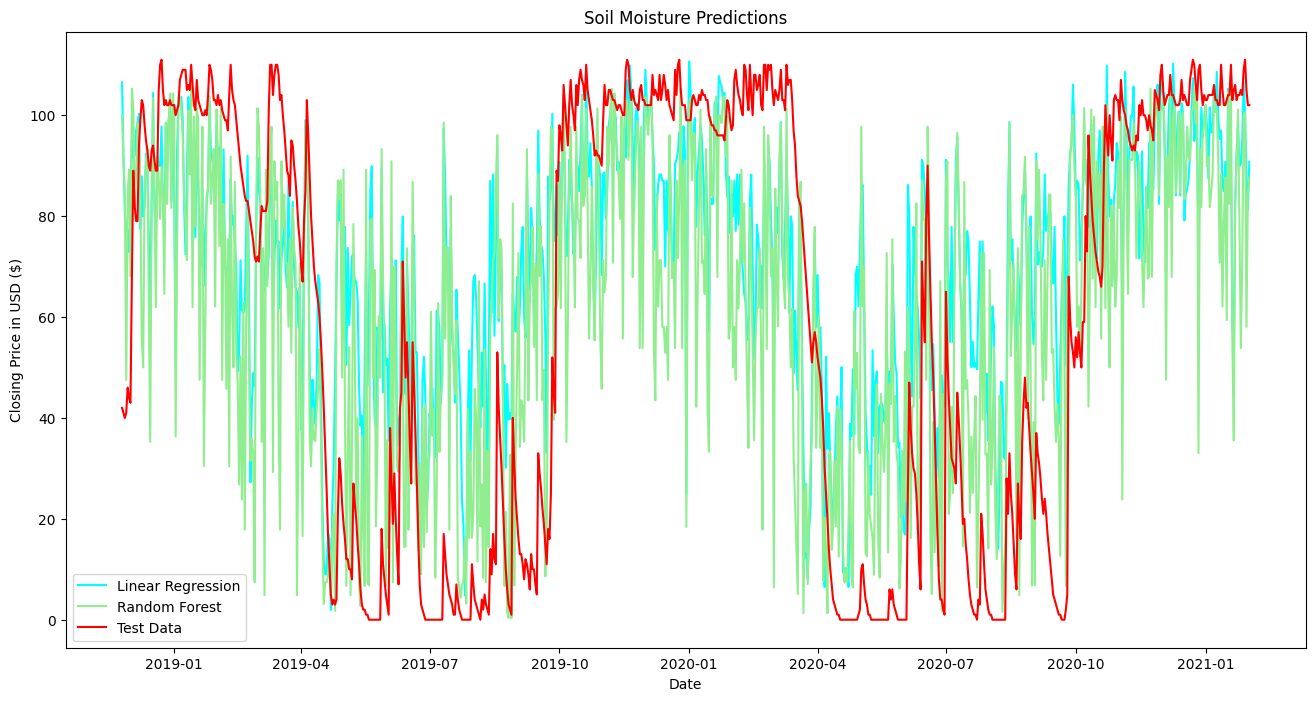

In [22]:
plt.figure(figsize=(16,8))
plt.title('Soil Moisture Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD ($)')


plt.plot(predictions['Prediction_Linear'][:800], label = 'Linear Regression', color = 'cyan')
plt.plot(predictions['Prediction_Forest'][:800], label = "Random Forest", color = 'lightgreen')
plt.plot(predictions['Actuals'][:800], label = 'Test Data', color = 'red')
plt.legend()
plt.show()

In [23]:
print('LINEAR REGRESSION: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, lr_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, lr_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, lr_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, lr_pred), 4))
print(f'Train Score: {linear.score(X_train, y_train) * 100:.2f}% and Test Score: {linear.score(X_test, y_test) * 100:.2f}% using Linear Regression.')
print('')
print('RANDOM FOREST REGRESSOR: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, forest_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, forest_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, forest_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, forest_pred), 4))
print(f'Train Score: {forest.score(X_train, y_train) * 100:.2f}% and Test Score: {forest.score(X_test, y_test) * 100:.2f}% using Random Forest Regressor.')

LINEAR REGRESSION: 
-------------------------------------------
Mean Absolute Error: 27.3437
Mean Squared Error: 1102.2819
Root Mean Squared Error: 33.2006
(R^2) Score: 0.2903
Train Score: 36.08% and Test Score: 29.03% using Linear Regression.

RANDOM FOREST REGRESSOR: 
-------------------------------------------
Mean Absolute Error: 27.3837
Mean Squared Error: 1167.1542
Root Mean Squared Error: 34.1636
(R^2) Score: 0.2485
Train Score: 41.79% and Test Score: 24.85% using Random Forest Regressor.


In [24]:
FORECAST = 1
df2['Prediction'] = df2[['BF10']].shift(-FORECAST)

In [25]:
# Create X and y variables shifted by the number of days we want to predict.
X = df2[['BF10']][:-FORECAST]
y = df2[['Prediction']][:-FORECAST]

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)
y = sc.fit_transform(y)

# Divide the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)

 (9057, 1) 
 (9057, 1) 
 (2265, 1) 
 (2265, 1)


In [26]:
forest = RandomForestRegressor().fit(X_train, y_train)
linear = LinearRegression().fit(X_train, y_train)

/tmp/ipykernel_321/4150774867.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest = RandomForestRegressor().fit(X_train, y_train)


In [27]:
y_test

array([[0.91891892],
       [0.9009009 ],
       [0.9009009 ],
       ...,
       [0.96396396],
       [0.93693694],
       [0.90990991]])

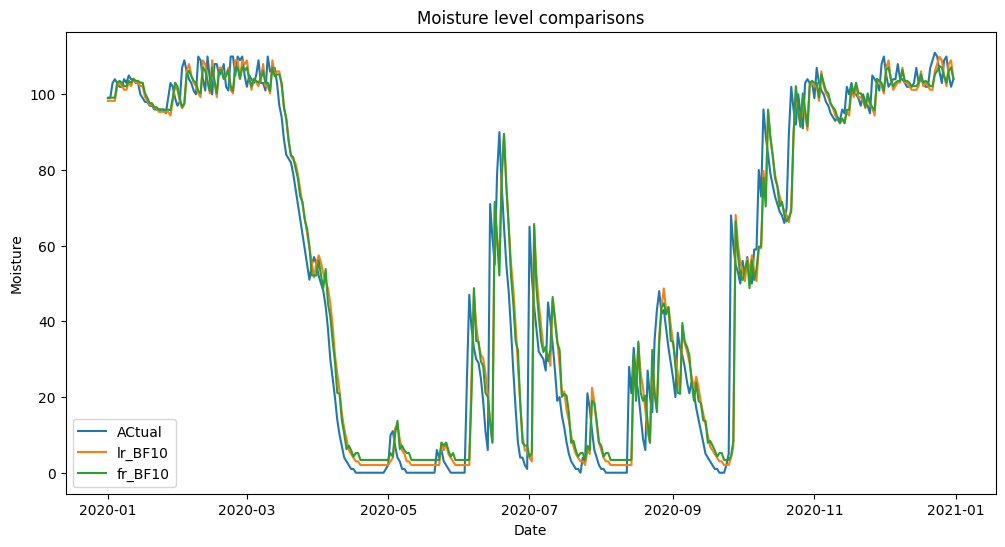

In [28]:
forest_pred = forest.predict(X_test)
lr_pred = linear.predict(X_test)

forest_pred = sc.inverse_transform(forest_pred.reshape(-1, 1))
lr_pred = sc.inverse_transform(lr_pred.reshape(-1, 1))

prediction = pd.DataFrame(lr_pred, index=df2[9057+FORECAST:].index, columns = ['lr_BF10'])
prediction['fr_BF10'] = forest_pred
prediction['Actuals'] = sc.inverse_transform(y_test.reshape(-1, 1))

prediction['lr_BF10'] = prediction[['lr_BF10']].shift(FORECAST)
prediction['fr_BF10'] = prediction[['fr_BF10']].shift(FORECAST)

plt.figure(figsize=(12,6))
plt.plot(prediction['Actuals']['2020'], label = 'ACtual')
plt.plot(prediction['lr_BF10']['2020'], label = 'lr_BF10')
plt.plot(prediction['fr_BF10']['2020'], label = 'fr_BF10')
plt.legend()
plt.title('Moisture level comparisons')  
plt.ylabel("Moisture")
plt.xlabel('Date')
plt.show()

In [29]:
print('LINEAR REGRESSION: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, lr_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, lr_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, lr_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, lr_pred), 4))
print(f'Train Score: {linear.score(X_train, y_train) * 100:.2f}% and Test Score: {linear.score(X_test, y_test) * 100:.2f}% using Linear Regression.')
print('')
print('RANDOM FOREST REGRESSOR: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, forest_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, forest_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, forest_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, forest_pred), 4))
print(f'Train Score: {forest.score(X_train, y_train) * 100:.2f}% and Test Score: {forest.score(X_test, y_test) * 100:.2f}% using Random Forest Regressor.')

LINEAR REGRESSION: 
-------------------------------------------
Mean Absolute Error: 61.9511
Mean Squared Error: 5319.3147
Root Mean Squared Error: 72.9336
(R^2) Score: -41072.9279
Train Score: 94.54% and Test Score: 95.68% using Linear Regression.

RANDOM FOREST REGRESSOR: 
-------------------------------------------
Mean Absolute Error: 62.0051
Mean Squared Error: 5318.34
Root Mean Squared Error: 72.9269
(R^2) Score: -41065.4009
Train Score: 94.70% and Test Score: 95.66% using Random Forest Regressor.


In [49]:
def sliding_window_2D_from_df(df, targetcol_series, TIME_WINDOW, FORECAST_DISTANCE):
    X_df = pd.concat([df.shift(i) for i in range(1,TIME_WINDOW+1)], axis=1)\
                      .iloc[TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1]
    X_df.columns = pd.MultiIndex.from_product([range(1,TIME_WINDOW+1), df.columns])
    X_df.rename_axis(["lag", "variable"], axis=1, inplace=True)

    y_series = targetcol_series.shift( -FORECAST_DISTANCE + 1 )\
                      .iloc[ TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1 ]
    return X_df, y_series

def rolled_X_from_2D_sliding_window_df(X_df, timesteps):
    X_rolled = X_df.values.reshape(X_df.shape[0], timesteps, -1)
    return X_rolled

In [50]:
TIME_WINDOW=365
FORECAST_DISTANCE=30

targetcol = "BF10"
targetcol_series = df2[targetcol].astype('int32')

## train valid test split
X_train, X_test, y_train, y_test = train_test_split(df2[["BF10"]].astype('int32'), targetcol_series, test_size=0.2, shuffle=False)


print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)
print()

X_train, y_train = sliding_window_2D_from_df(X_train, y_train, TIME_WINDOW, FORECAST_DISTANCE)
X_test, y_test = sliding_window_2D_from_df(X_test, y_test, TIME_WINDOW, FORECAST_DISTANCE)


print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)
print()

# for lstm
X_train = rolled_X_from_2D_sliding_window_df(X_train, TIME_WINDOW)
X_test = rolled_X_from_2D_sliding_window_df(X_test, TIME_WINDOW)


y_train = y_train.ravel().reshape(-1,1)
y_test = y_test.ravel().reshape(-1,1)

print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)
print()

 (9058, 1) 
 (9058,) 
 (2265, 1) 
 (2265,)

 (8664, 365) 
 (8664,) 
 (1871, 365) 
 (1871,)

 (8664, 365, 1) 
 (8664, 1) 
 (1871, 365, 1) 
 (1871, 1)



In [51]:
linear = LinearRegression()
linear.fit(X_train.reshape(X_train.shape[0], TIME_WINDOW), y_train)
predictions = linear.predict(X_test.reshape(X_test.shape[0],TIME_WINDOW))
error = metrics.mean_squared_error(y_test, predictions)
accuracy = metrics.r2_score(y_test, predictions)*100
print('Test MSE: %.3f' % error)
print('Accuracy : %.3f' % accuracy)

Test MSE: 754.742
Accuracy : 53.768


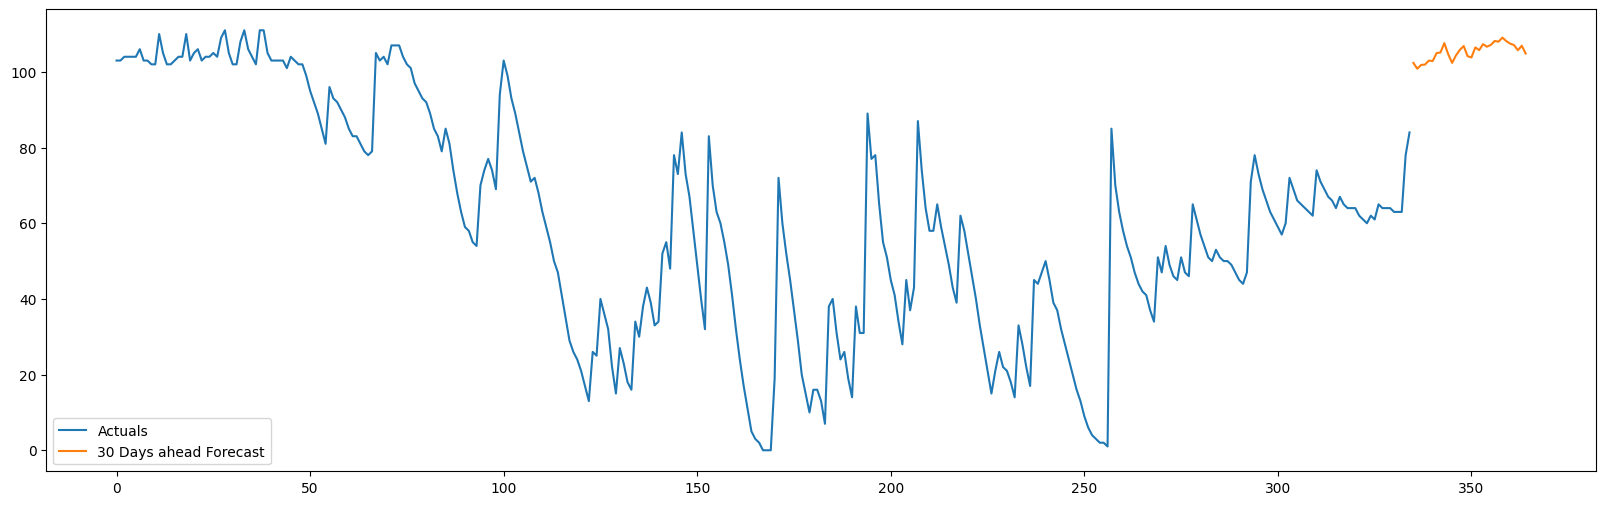

In [63]:
input = X_test[-1:].reshape(1,-1)
history = [x for x in df2['BF10'].values]
forecast = []

for i in range(30):
    yhat = linear.predict(input)
    input = list(input[0])
    pred = yhat[0][0]
    forecast.append(pred)
    input.append(pred)
    input = np.array(input[-TIME_WINDOW:]).reshape(1,TIME_WINDOW)
    
plt.figure(figsize = (20,6))
plt.plot(history[-TIME_WINDOW:-30], label='Actuals')
plt.plot(range(TIME_WINDOW-30,TIME_WINDOW),forecast, label ='30 Days ahead Forecast')
plt.legend()
plt.show()

## LSTM Method

In [64]:
df2 = df2.drop('Prediction', 1)

/tmp/ipykernel_321/245969498.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop('Prediction', 1)


In [65]:
TIME_WINDOW=180
FORECAST_DISTANCE=30

targetcol = "BF10"
targetcol_series = df2[targetcol].astype('int32')

X_train, X_else, targetcol_series_train, targetcol_series_else = train_test_split(df2[["BF10"]].astype('int32'), targetcol_series, test_size=0.2, shuffle=False)
X_valid, X_test, targetcol_series_valid, targetcol_series_test = train_test_split(X_else, targetcol_series_else, test_size=0.5, shuffle=False)

X_df_train, y_train = sliding_window_2D_from_df(X_train, targetcol_series_train, TIME_WINDOW, FORECAST_DISTANCE)
X_df_valid, y_valid = sliding_window_2D_from_df(X_valid, targetcol_series_valid, TIME_WINDOW, FORECAST_DISTANCE)
X_df_test, y_test = sliding_window_2D_from_df(X_test, targetcol_series_test, TIME_WINDOW, FORECAST_DISTANCE)

X_rolled_train = rolled_X_from_2D_sliding_window_df(X_df_train, TIME_WINDOW)
X_rolled_valid = rolled_X_from_2D_sliding_window_df(X_df_valid, TIME_WINDOW)
X_rolled_test = rolled_X_from_2D_sliding_window_df(X_df_test, TIME_WINDOW)

y_train = y_train.ravel().reshape(-1,1)
y_valid = y_valid.ravel().reshape(-1,1)
y_test = y_test.ravel().reshape(-1,1)

print()
print("", X_rolled_train.shape, "\n", y_train.shape,
      "\n", X_rolled_valid.shape, "\n", y_valid.shape,
      "\n", X_rolled_test.shape, "\n", y_test.shape)


 (8849, 180, 1) 
 (8849, 1) 
 (923, 180, 1) 
 (923, 1) 
 (924, 180, 1) 
 (924, 1)


In [66]:
from tensorflow.keras import backend as be

LEARNING_RATE = 0.1
N_CELLS = 50
KERNEL = 'GlorotNormal'

## number of input variables: the final dimension in the 3D prepared data (index 2)
column_count=X_rolled_train.shape[2]

be.clear_session()

model = Sequential()
model.add(LSTM(N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences=True, input_shape = (TIME_WINDOW, column_count)))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

## remember, we're doing regression, so choose loss (and output layer) accordingly!
model.compile(loss='mean_squared_error', optimizer='adamax')

print(model.summary())

2022-12-15 10:06:32.310097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-15 10:06:32.310124: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 10:06:32.310155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: rrompf-Desktop
2022-12-15 10:06:32.310165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: rrompf-Desktop
2022-12-15 10:06:32.310272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-12-15 10:06:32.310323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reporte

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 180, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 180, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 180, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [67]:
EPOCHS = 40
BATCH_SIZE = 200

# Crate a callback for efficiency purposes
my_callback = EarlyStopping(monitor='loss',
                            patience=3,
                            restore_best_weights = True)

history = model.fit(x=X_rolled_train,
                    y=y_train, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_rolled_valid,y_valid), 
                    epochs=EPOCHS,
                    verbose=1, 
                    shuffle=False,
                    callbacks = my_callback)

Epoch 1/40
45/45 [==============================] - 30s 500ms/step - loss: 6051.3032 - val_loss: 4087.3420
Epoch 2/40
45/45 [==============================] - 20s 451ms/step - loss: 5272.4541 - val_loss: 3740.0544
Epoch 3/40
45/45 [==============================] - 20s 452ms/step - loss: 4950.2173 - val_loss: 3572.2573
Epoch 4/40
45/45 [==============================] - 20s 452ms/step - loss: 4746.6333 - val_loss: 3434.5122
Epoch 5/40
45/45 [==============================] - 20s 453ms/step - loss: 4559.4497 - val_loss: 3306.6938
Epoch 6/40
45/45 [==============================] - 20s 454ms/step - loss: 4388.7202 - val_loss: 3186.8435
Epoch 7/40
45/45 [==============================] - 20s 453ms/step - loss: 4220.7944 - val_loss: 3073.4253
Epoch 8/40
45/45 [==============================] - 21s 458ms/step - loss: 4064.2097 - val_loss: 2965.4507
Epoch 9/40
45/45 [==============================] - 21s 459ms/step - loss: 3915.9766 - val_loss: 2863.4543
Epoch 10/40
45/45 [==================

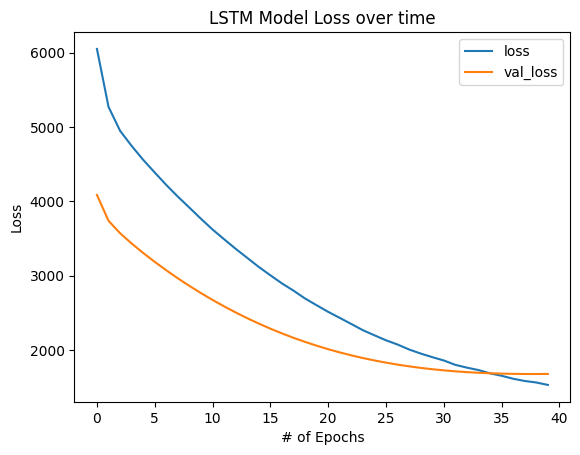

In [68]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss over time')
plt.legend()
plt.show()

In [69]:
test_pred = model.predict(X_rolled_test).flatten()

29/29 [==============================] - 3s 58ms/step


In [71]:
test_pred.mean()

58.637085

# ARIMA MODEL

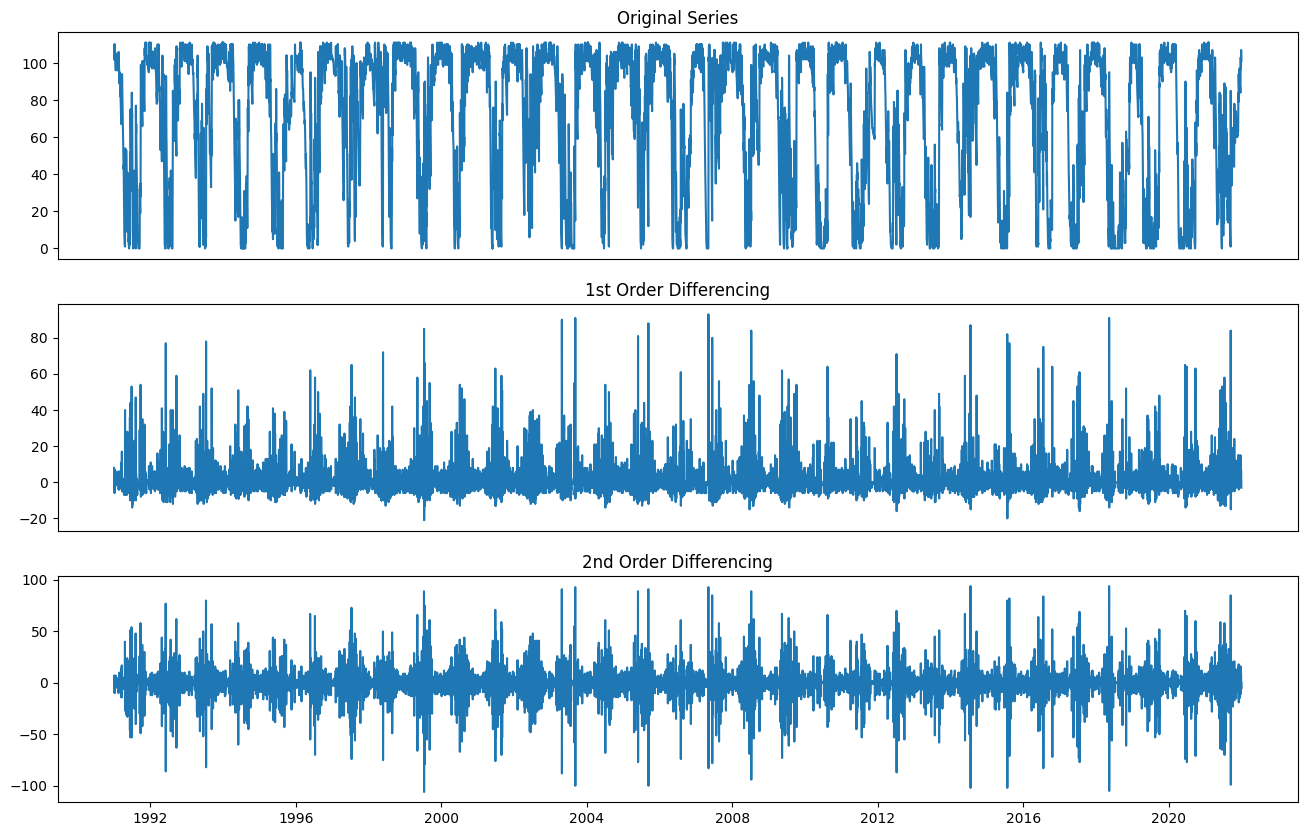

In [ ]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 10))
ax1.plot(df2.BF10)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df2.BF10.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df2.BF10.diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

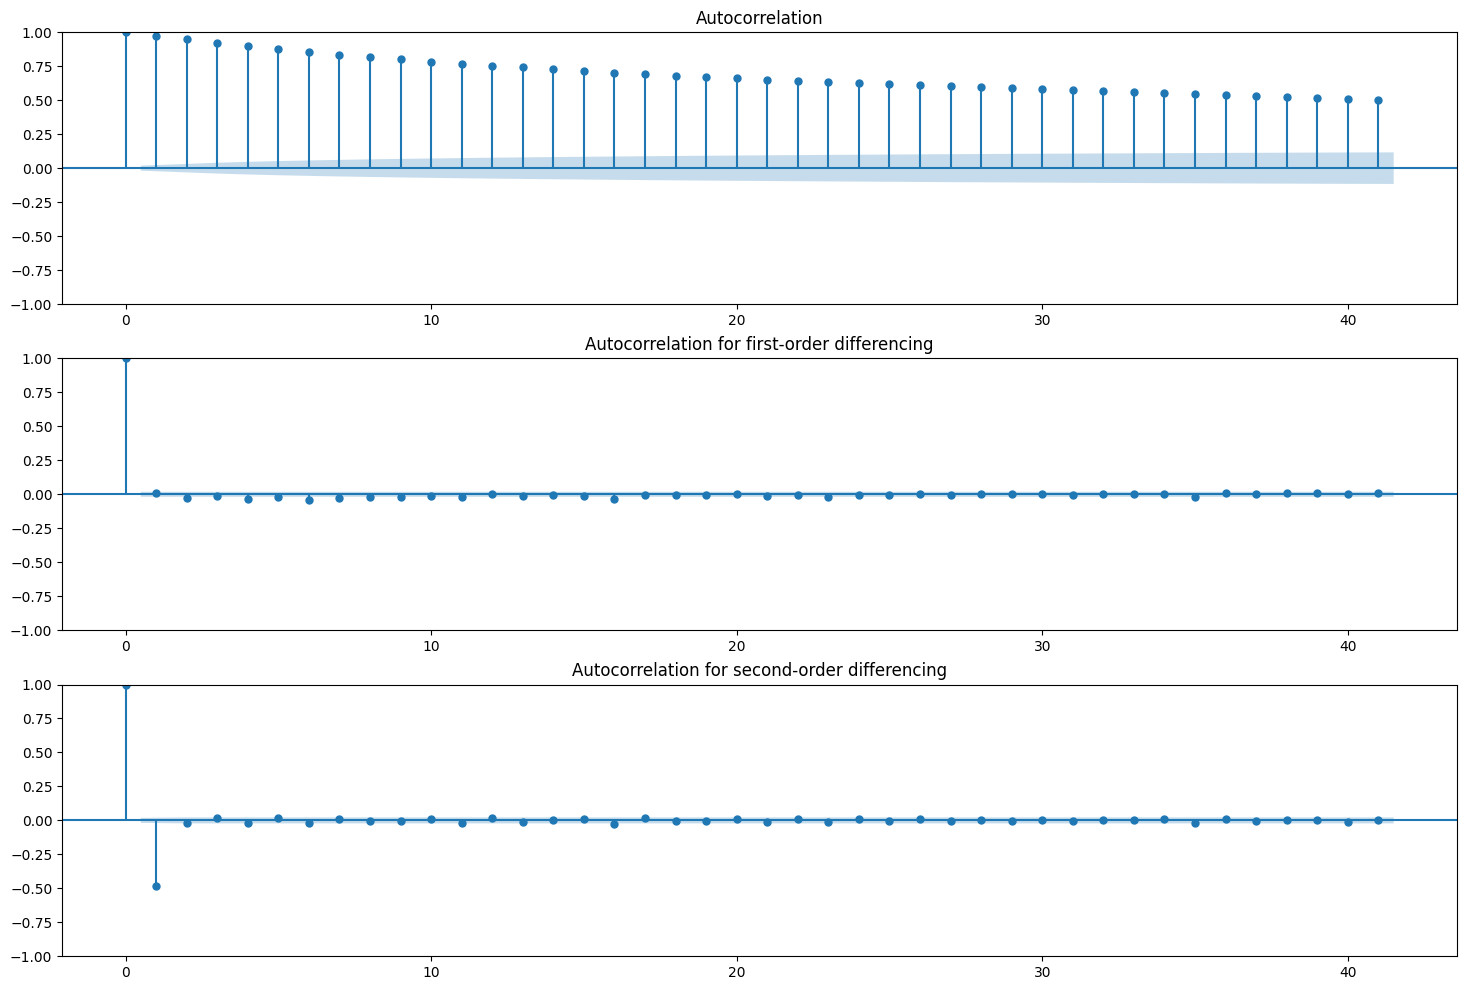

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12))
_ = plot_acf(df2.BF10, ax=ax1)
_ = plot_acf(df2.BF10.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(df2.BF10.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

/run/media/rrompf/Nový zväzok/code/Machine_Learning_and_Deep_Learning/.venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0, 0.5, 'Correlation coefficient')

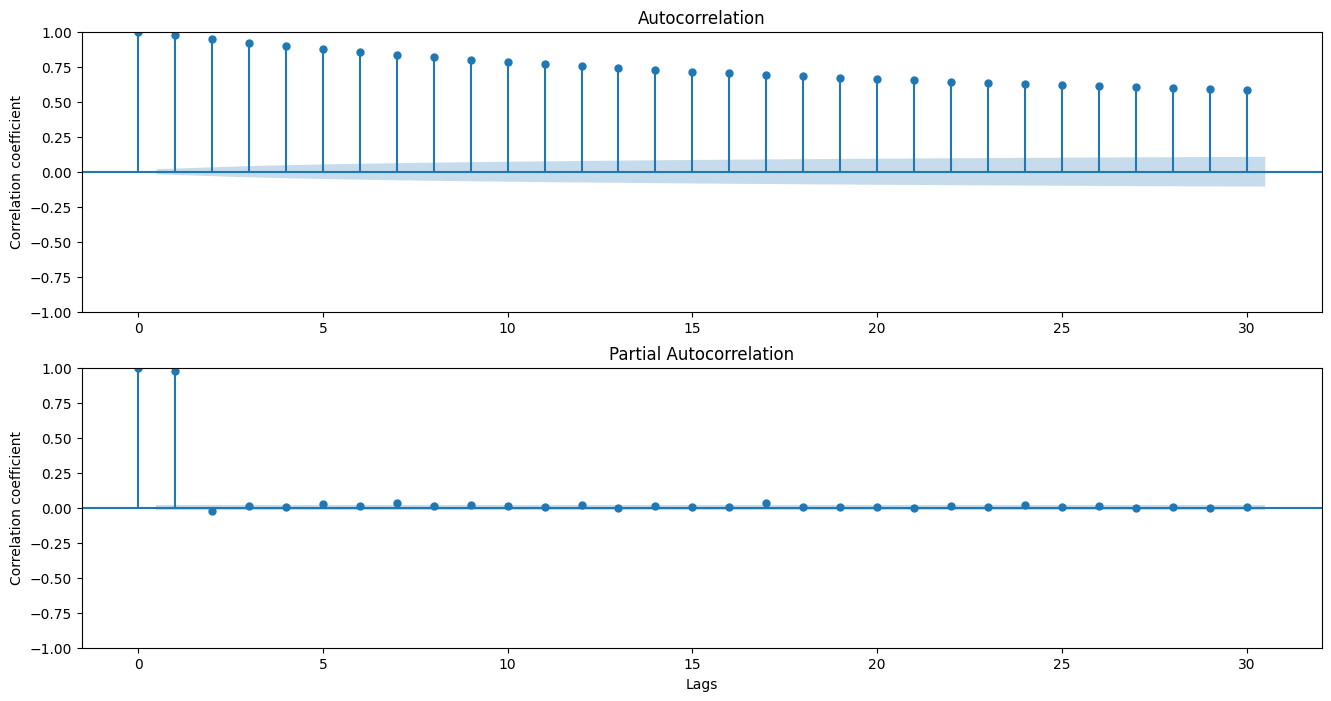

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
ax1.set_title('Autocorrelation')
_ = plot_acf(df2['BF10'], lags=30, ax = ax1)
ax2.set_title('Partial Autocorrelation')
_ = plot_pacf(df2['BF10'], lags=30, ax = ax2)
ax1.set_ylabel("Correlation coefficient")
ax2.set_xlabel("Lags")
ax2.set_ylabel("Correlation coefficient")